In [1]:
import tensorflow as tf
from tensorflow import keras
from packaging import version
from datetime import datetime
import pandas as pd
import numpy as np
import os
import glob

In [21]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.11.0


In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [23]:
tf.test.gpu_device_name()

''

In [2]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos]

['/device:CPU:0']

In [3]:
import tensorboard
tensorboard.__version__

'2.11.0'

In [4]:
from linkmethods import get_pageviews, get_target, get_backlink_views

In [5]:
from keras.models import Sequential
from keras.layers import *

In [35]:
df_meisen= get_target("Meisen")

In [29]:
from zeitreihenanalyse import pageviewget
from linksAnalysis import get_back_links

In [32]:
flatten_views = get_backlink_views("Meisen", get_target("Meisen"))
flatten_views

[array([2., 0., 4., ..., 1., 0., 3.]),
 array([ 7., 10.,  6., ..., 11., 14.,  9.]),
 array([1678, 1719, 1764, ..., 2974, 2838, 1921], dtype=int64),
 array([0., 0., 0., ..., 2., 1., 0.]),
 array([31, 38, 39, ..., 20, 23, 26], dtype=int64),
 array([16., 12., 15., ..., 36., 32., 18.]),
 array([39, 24, 31, ..., 47, 28, 49], dtype=int64),
 array([14, 22, 10, ..., 22, 24, 21], dtype=int64),
 array([11., 13.,  8., ...,  5., 11., 16.]),
 array([0., 0., 0., ..., 3., 4., 4.]),
 array([1., 1., 0., ..., 2., 1., 0.]),
 array([11., 10., 19., ..., 15.,  7., 13.]),
 array([248, 225, 235, ..., 353, 341, 264], dtype=int64),
 array([0., 0., 0., ..., 4., 1., 0.]),
 array([0., 0., 1., ..., 2., 1., 3.]),
 array([1., 0., 1., ..., 0., 1., 0.]),
 array([ 64,  57,  72, ..., 184, 172, 115], dtype=int64),
 array([292, 287, 290, ..., 330, 417, 214], dtype=int64),
 array([ 4.,  6.,  5., ...,  8., 19., 18.]),
 array([271, 253, 235, ..., 370, 367, 334], dtype=int64),
 array([1., 1., 1., ..., 2., 0., 1.]),
 array([3.,

In [33]:
data = np.array(flatten_views).reshape((162,2558,1))
data.shape

(162, 2558, 1)

In [36]:
target = np.array(df_meisen.views)
target = np.array([np.copy(target) for _ in range((data.shape[0]))])

target.shape

(162, 2558)

In [221]:
# Define the model.
model = Sequential()

# 1 dense hidden layer with 250 nodes ~90+ acc
model.add(Input(shape=(2558,))) # Input tensor
model.add(Dense(units=1229)) # hidden layer 1,
model.add(Dense(units=2558)) #output layer


model.compile(
    optimizer='Adagrad',
    loss='MeanSquaredError',
    metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 1229)              3145011   
                                                                 
 dense_63 (Dense)            (None, 2558)              3146340   
                                                                 
Total params: 6,291,351
Trainable params: 6,291,351
Non-trainable params: 0
_________________________________________________________________


In [225]:
# Train the model.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=75, restore_best_weights=True)
history = model.fit(
    data,
    target,
    batch_size=8,
    epochs=450,
    validation_split=0.10,
    callbacks=[tensorboard_callback, early_stop])

Epoch 1/450
19/19 [==============================] - 1s 64ms/step - loss: 122023.3906 - accuracy: 0.0000e+00 - val_loss: 131342.5156 - val_accuracy: 0.0000e+00
Epoch 2/450
19/19 [==============================] - 1s 59ms/step - loss: 207710.5312 - accuracy: 0.0000e+00 - val_loss: 126639.0625 - val_accuracy: 0.0000e+00
Epoch 3/450
19/19 [==============================] - 1s 65ms/step - loss: 1623206.1250 - accuracy: 0.0000e+00 - val_loss: 146328.3125 - val_accuracy: 0.0000e+00
Epoch 4/450
19/19 [==============================] - 1s 62ms/step - loss: 1553424.6250 - accuracy: 0.0000e+00 - val_loss: 166253.7031 - val_accuracy: 0.0000e+00
Epoch 5/450
19/19 [==============================] - 1s 60ms/step - loss: 2482281.0000 - accuracy: 0.0138 - val_loss: 138691.1719 - val_accuracy: 0.0588
Epoch 6/450
19/19 [==============================] - 1s 59ms/step - loss: 1040448.7500 - accuracy: 0.0000e+00 - val_loss: 131363.7656 - val_accuracy: 0.0000e+00
Epoch 7/450
19/19 [=========================

In [226]:
from matplotlib import pyplot as plt


def display_learning_curves(history):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    axs[0,0].plot(history.history["loss"])
    axs[0,0].legend(["train", "test"], loc="upper right")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss")

    axs[0,1].plot(history.history["accuracy"])
    axs[0,1].legend(["train", "test"], loc="upper right")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Accuracy")

    axs[1,0].plot(history.history["val_loss"])
    axs[1,0].legend(["train", "test"], loc="upper right")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("val_loss")

    axs[1,1].plot(history.history["val_accuracy"])
    axs[1,1].legend(["train", "test"], loc="upper right")
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("val_Accuracy")
    plt.show()

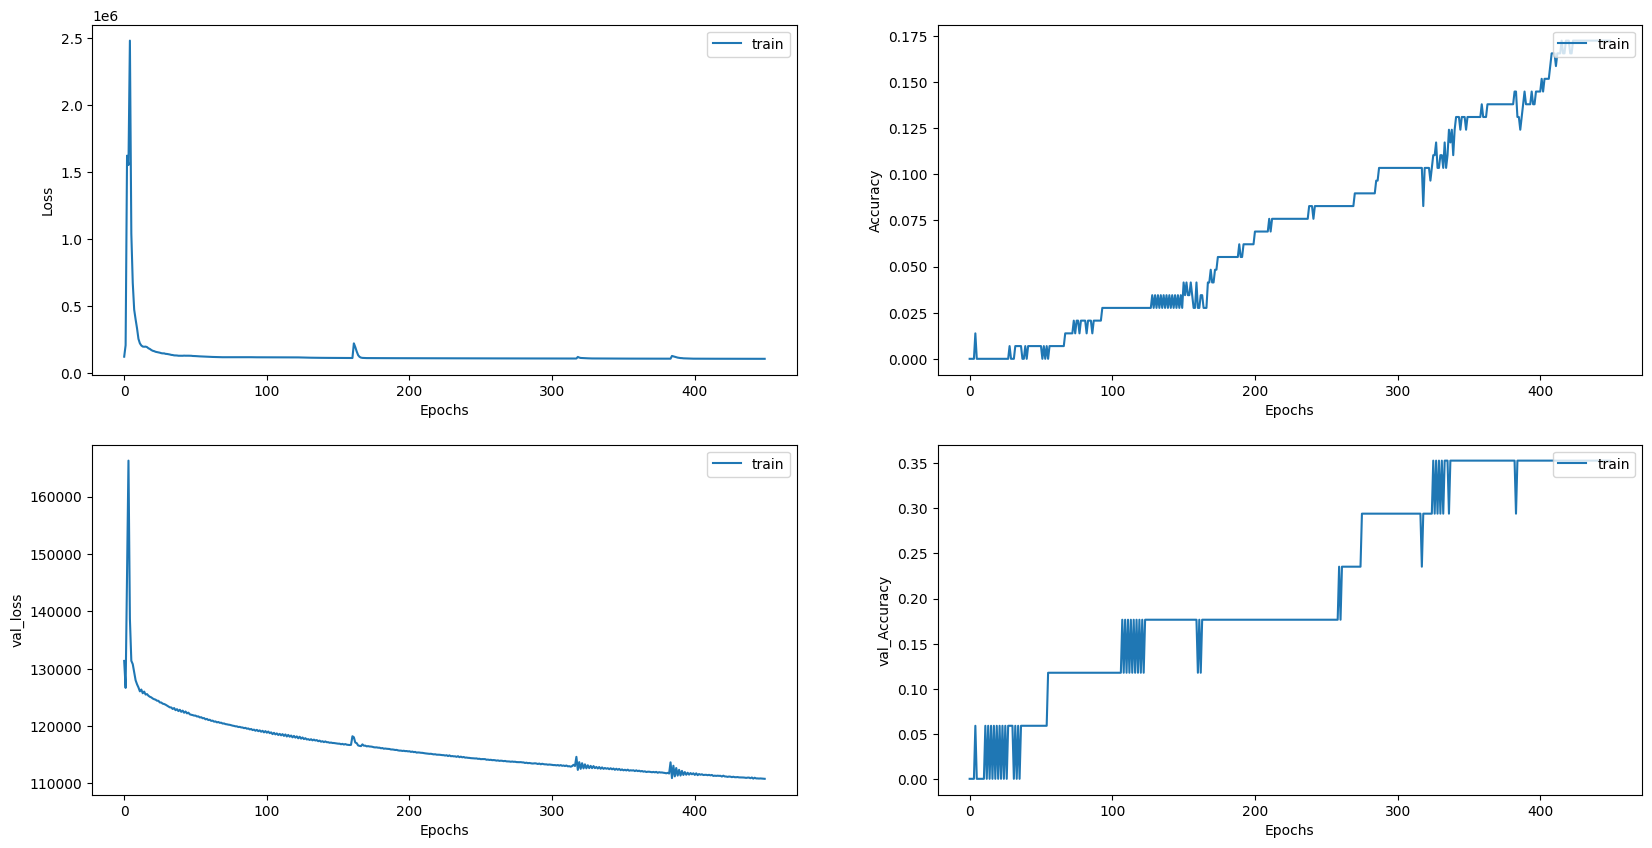

In [227]:
display_learning_curves(history)

In [124]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [70]:
%tensorboard --logdir logs/fit --host localhost --port 8088

Launching TensorBoard...

In [69]:
graph = tf.placeholder(tf.int32, shape=[162, 2558,1])
node_features = tf.placeholder(tf.int32, shape=[162, 2558,1])
labels = tf.placeholder(tf.int32, shape=[162, 2558,1])

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (2022872164.py, line 1)

In [ ]:
from tensorflow import grap

In [ ]:
hidden = graph_convolution(node_features, graph)
logits = fully_connected(hidden, num_classes)
predictions = tf.nn.softmax(logits)